# 4 - Feras Formidáveis

## 4.14 A liga ternária leve mais cara do mundo

**Autores:** 

Enzo Januzzi Xavier

Rafael Anis Shaikhzadeh Santos

**Contribuição:** Ambos discutiram o problema, o conceito da fronteira de Pareto e fizeram o código juntos. 

### Introdução:

O objetivo desta atividade é encontrar uma liga de três elementos que tenha o maior custo e o menor peso atômico possível utilizando algoritmos genéticos. A liga ternária deve ser da forma **`x A . y B . z C`** sendo que 

$$
\begin{cases}
x + y + z = 100\,\mathrm{g} \\
x \geq 5\,\mathrm{g} \\
y \geq 5\,\mathrm{g} \\
z \geq 5\,\mathrm{g}
\end{cases}
$$

e *A*, *B* e *C* são elementos químicos diferentes. O preço e o peso de cada elemento disponível está definido abaixo. Considerou-se que qualquer composto com 3 elementos químicos é chamado de liga, desprezando equivalência química nas fórmulas.

Essa atividade é similar ao problema resolvido anteriormente, disponível [nesse link](Fera_4.13.ipynb). O diferencial é que agora temos 2 propriedades a serem otimizadas, sendo um problema multi-objetivo. Problemas desse tipo constituem a chamada **Fronteira de Pareto**.

A Fronteira de Pareto é um gráfico que compara a performance de 2 ou mais objetivos a serem otimizados, definindo um limiar para as possíveis soluções de um problema. [1] Por exemplo, na figura abaixo, há um problema multi-objetivo de maximização e minimização, em que existem diversas soluções possíveis. As soluções dominadas, em verde, representam soluções sub-ótimas; apesar de serem bons candidatos, existem soluções que as superam nessa otimização. Enquanto isso, as solução não dominadas, em azul, não são superadas por outras solução em todos os critérios, formando a própria Fronteira. Por fim, a região amarela é aquela até então inalcançada pela ciência.

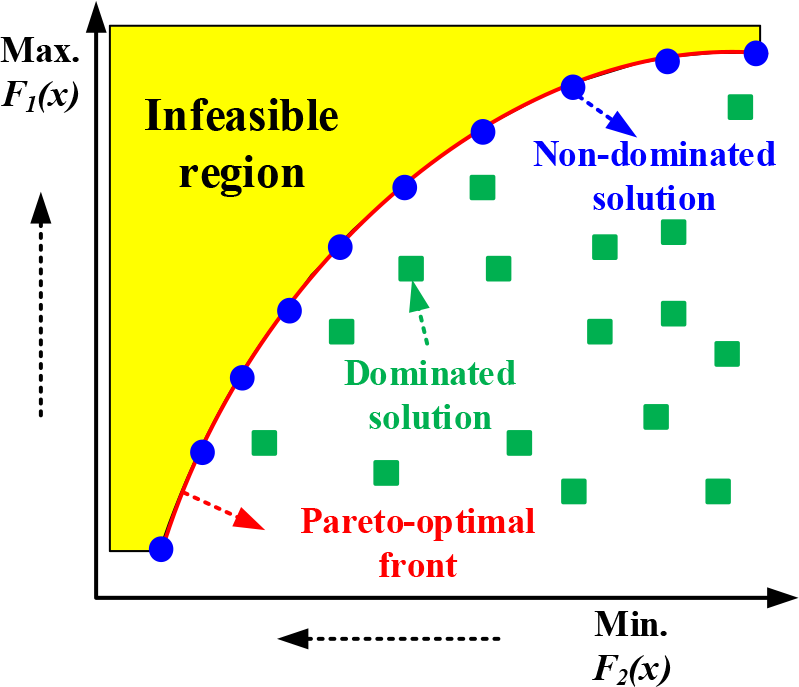

Figure 1: Pareto‐optimal front curves a Max–Min compromise between two objective functions. Retirado de um artigo da ResearchGate [2]

Tendo em mente a Fronteira de Pareto e que existem várias soluções não dominantes para esse problema multi-ojbetivo, este notebook busca encontrar apenas uma dessas soluções, não embarcando todos os pontos da fronteira.

### Desenvolvimento:

Importando as bibliotecas necessárias [2,3] e os scripts, baseados no material de aula do professor Daniel Cassar [4,5]:

In [14]:
import random
from functools import partial

from Scripts import funcao_objetivo_pop_liga_leve
from Scripts import populacao_liga as cria_populacao
from Scripts import selecao_torneio_max as funcao_selecao
from Scripts import cruzamento_ordenado as funcao_cruzamento
from Scripts import mutacao_elemento as funcao_mutacao

Segue o dicionário de elementos e preços concedidos pela questão.

In [15]:
# preço em dólares por quilograma
DIC_PRECO = {
    "H": 1.39, "He": 24, "Li": 85.6, "Be": 857, "B": 3.68, "C": 0.122, "N": 0.14, "O": 0.154, "F": 2.16, "Ne": 240,
    "Na": 3.43, "Mg": 2.32, "Al": 1.79, "Si": 1.7, "P": 2.69, "S": 0.0926, "Cl": 0.082, "Ar": 0.931, "K": 13.6,
    "Ca": 2.35, "Sc": 3460, "Ti": 11.7, "V": 385, "Cr": 9.4, "Mn": 1.82, "Fe": 0.424, "Co": 32.8, "Ni": 13.9,
    "Cu": 6, "Zn": 2.55, "Ga": 148, "Ge": 1010, "As": 1.31, "Se": 21.4, "Br": 4.39, "Kr": 290, "Rb": 15500,
    "Sr": 6.68, "Y": 31, "Nb": 85.6, "Mo": 40.1, "Tc": 100000, "Ru": 10600, "Rh": 147000, "Pd": 49500, "Ag": 521,
    "Cd": 2.73, "In": 167, "Sn": 18.7, "Sb": 5.79, "Te": 63.5, "I": 35, "Xe": 1800, "Cs": 61800, "Ba": 0.275,
    "La": 4.92, "Ce": 4.71, "Pr": 103, "Nd": 57.5, "Pm": 460000, "Sm": 13.9, "Eu": 31.4, "Gd": 28.6, "Tb": 658,
    "Dy": 307, "Ho": 57.1, "Er": 26.4, "Tm": 3000, "Yb": 17.1, "Lu": 643, "Hf": 900, "Ta": 312, "W": 35.3,
    "Re": 4150, "Os": 12000, "Ir": 56200, "Pt": 27800, "Hg": 30.2, "Tl": 4200, "Pb": 2, "Bi": 6.36, "Po": 49200000000000,
    "Ac": 29000000000000, "Th": 287, "Pa": 280000, "U": 101, "Np": 660000, "Pu": 6490000, "Am": 750000,
    "Cm": 160000000000, "Bk": 185000000000, "Cf": 185000000000,
}

Definindo também o dicionário com os pesos atômicos de cada elemento.

In [16]:
# peso atômico em gramas por mol
DIC_PESO = {
    "H": 1.008, "He": 4.002602, "Li": 6.94, "Be": 9.0121831, "B": 10.81, "C": 12.011, "N": 14.007, "O": 15.999, "F": 18.998403163, "Ne": 20.1797,
    "Na": 22.98976928, "Mg": 24.305, "Al": 26.9815385, "Si": 28.085, "P": 30.973761998, "S": 32.06, "Cl": 35.45, "Ar": 39.948, "K": 39.0983,
    "Ca": 40.078, "Sc": 44.955908, "Ti": 47.867, "V": 50.9415, "Cr": 51.9961, "Mn": 54.938044, "Fe": 55.845, "Co": 58.933194, "Ni": 58.6934,
    "Cu": 63.546, "Zn": 65.38, "Ga": 69.723, "Ge": 72.63, "As": 74.921595, "Se": 78.971, "Br": 79.904, "Kr": 83.798, "Rb": 85.4678,
    "Sr": 87.62, "Y": 88.90584, "Nb": 92.90637, "Mo": 95.95, "Tc": 97.90721, "Ru": 101.07, "Rh": 102.9055, "Pd": 106.42, "Ag": 107.8682,
    "Cd": 112.414, "In": 114.818, "Sn": 118.71, "Sb": 121.76, "Te": 127.6, "I": 126.90447, "Xe": 131.293, "Cs": 132.90545196, "Ba": 137.327,
    "La": 138.90547, "Ce": 140.116, "Pr": 140.90766, "Nd": 144.242, "Pm": 144.91276, "Sm": 150.36, "Eu": 151.964, "Gd": 157.25, "Tb": 158.92535,
    "Dy": 162.5, "Ho": 164.93033, "Er": 167.259, "Tm": 168.93422, "Yb": 173.045, "Lu": 174.9668, "Hf": 178.49, "Ta": 180.94788, "W": 183.84,
    "Re": 186.207, "Os": 190.23, "Ir": 192.217, "Pt": 195.084, "Hg": 200.592, "Tl": 204.38, "Pb": 207.2, "Bi": 208.9804, "Po": 209.0,
    "Ac": 227.0, "Th": 232.0377, "Pa": 231.03588, "U": 238.02891, "Np": 237.0, "Pu": 244.0, "Am": 243.0,
    "Cm": 247.0, "Bk": 247.0, "Cf": 251.0,
}

A estratégia para resolver esse problema foi considerar a razão entre o preço e o peso atômico de cada elemento, aqui chamada de densidade de valor por peso molecular. Seguindo essa ideia, podemos aproveitar a mesma lógica do problema anterior sobre manter constantes os valores de x, y e z como 90, 5 e 5 gramas, respectivamente. Assim, ara achar a liga mais valiosa e leve é lógico pegarmos a maior quantidade de elementos mais densos. Nesse caso, o peso máximo possível de um mesmo elemento é 90 gramas - definido pelo enunciado (100-5-5 = 90). Os outros dois elementos terão 5 gramas, visto que é o mínimo necessário.

Nota: já que os valores dos elementos são dado em dolár/kg vamos por x,y,z em kg também.

In [17]:
ELEMENTOS = list(DIC_PRECO.keys())
TAMANHO_LIGA = 3
XYZ = [0.09, 0.005, 0.005]

NUM_GERACOES = 1000
TAMANHO_POPULACAO = 100
CHANCE_DE_CRUZAMENTO = 0.5
CHANCE_DE_MUTACAO = 0.025
CHANCE_DE_MUTACAO_TAMANHO = 0.05
TAMANHO_TORNEIO = 3

In [18]:
funcao_objetivo = partial(funcao_objetivo_pop_liga_leve, 
                          elementos_possiveis = ELEMENTOS, 
                          dic_precos = DIC_PRECO,
                          dic_pesos = DIC_PESO, 
                          xyz = XYZ)

Criando a população inicial do problema, em que cada indivíduo contém 3 elementos diferentes (A, B, C). Vale lembrar, de novo, que os valores de x,y e z são fixos.

In [19]:
populacao = cria_populacao(TAMANHO_POPULACAO, TAMANHO_LIGA, ELEMENTOS)
populacao

[['W', 'Y', 'Ce'],
 ['Sc', 'Yb', 'Nb'],
 ['Cd', 'Cu', 'Li'],
 ['P', 'Pm', 'Ne'],
 ['Pm', 'Lu', 'Br'],
 ['Ca', 'Sb', 'Tm'],
 ['Ti', 'Y', 'F'],
 ['Ag', 'Cs', 'Cu'],
 ['Ar', 'Ta', 'W'],
 ['Ac', 'Rb', 'C'],
 ['Re', 'Hg', 'Nb'],
 ['Ca', 'Ce', 'Os'],
 ['Sb', 'S', 'Nd'],
 ['Sn', 'Cu', 'Pu'],
 ['Pa', 'Sm', 'La'],
 ['Re', 'Xe', 'Nb'],
 ['Bi', 'Pr', 'Ru'],
 ['U', 'La', 'He'],
 ['Sr', 'As', 'Er'],
 ['Cl', 'K', 'Ti'],
 ['Ca', 'Mo', 'Cu'],
 ['Bk', 'Kr', 'Re'],
 ['Am', 'V', 'Fe'],
 ['Rh', 'Sc', 'Ga'],
 ['Mn', 'Ac', 'H'],
 ['Pr', 'Y', 'Cu'],
 ['Ba', 'Np', 'Gd'],
 ['U', 'Dy', 'Sn'],
 ['Ne', 'Sb', 'K'],
 ['Eu', 'Er', 'Cf'],
 ['Pm', 'N', 'Cl'],
 ['Mo', 'Sc', 'Pr'],
 ['Te', 'Bi', 'Ni'],
 ['Er', 'Fe', 'Cr'],
 ['Np', 'I', 'Bi'],
 ['Tc', 'Hf', 'Pu'],
 ['Ga', 'Sc', 'Tm'],
 ['Ga', 'Y', 'U'],
 ['Ho', 'Xe', 'Hf'],
 ['Pm', 'Sb', 'Er'],
 ['Pm', 'Ni', 'Ar'],
 ['Th', 'Ho', 'Ne'],
 ['Na', 'S', 'Li'],
 ['N', 'V', 'Ac'],
 ['N', 'Fe', 'Re'],
 ['Na', 'Yb', 'Re'],
 ['Ho', 'Bk', 'C'],
 ['F', 'P', 'Pr'],
 ['Mn', 'Ho', 'He'

O código principal, contendo um laço while para fazer todas as etapas do algoritmo genético (seleção, cruzamento, mutação e atualização da geração) até encontrar a liga mais densa. A função objetivo calcula o peso e preço total dos elementos da população, fazendo uma seleção por torneio buscando maximizar o fitness. Usou-se o cruzamento ordenado e a mutação de salto para alterar os elementos de cada liga, buscando encontrar o melhor candidato.

In [20]:
hall_da_fama = []

for n in range(NUM_GERACOES):
    
    # Seleção
    fitness = funcao_objetivo(populacao)        
    selecionados = funcao_selecao(populacao, fitness, TAMANHO_TORNEIO)
    
    # Cruzamento
    proxima_geracao = []
    for pai, mae in zip(selecionados[::2], selecionados[1::2]):
        individuo1, individuo2 = funcao_cruzamento(pai, mae, CHANCE_DE_CRUZAMENTO)
        proxima_geracao.append(individuo1)
        proxima_geracao.append(individuo2)
    
    # Mutação
    funcao_mutacao(proxima_geracao, CHANCE_DE_MUTACAO, ELEMENTOS)
    
    # Atualização do hall da fama
    fitness = funcao_objetivo(proxima_geracao)
        
    maior_fitness = max(fitness)
    indice = fitness.index(maior_fitness)
    hall_da_fama.append(proxima_geracao[indice])    
    
    # Encerramento
    populacao = proxima_geracao

In [26]:
fitness = funcao_objetivo(hall_da_fama)
maior_fitness = max(fitness)
indice = fitness.index(maior_fitness)
melhor_individuo_observado = hall_da_fama[indice]

preco = 0
peso = 0

for elemento, qtd in zip(melhor_individuo_observado, XYZ):
    preco += DIC_PRECO[elemento] * qtd
    peso += DIC_PESO[elemento] * qtd


print("O melhor indivíduo observado foi:")
print("Elementos:", melhor_individuo_observado)
print ('Pesos respectivo (kg):', XYZ)
print()

print ("Preço total (Dólares):", preco)
print ("Peso molecular total (g/mol):", peso)

print("Densidade de valor por peso molecular (Doláres*mol/g):", maior_fitness)

O melhor indivíduo observado foi:
Elementos: ['Po', 'Bk', 'Ac']
Pesos respectivo (kg): [0.09, 0.005, 0.005]

Preço total (Dólares): 4573925000000.0
Peso molecular total (g/mol): 21.18
Densidade de valor por peso molecular (Doláres*mol/g): 21829114329.90844


### Conclusão:

Assim, conseguimos encontramos uma liga ternária que aparenta ser um bom candidato para esse problema multiobjetivo - conseguir uma liga de alto custo e de baixo peso molecular. Esperamos assim ter conseguindo um dos pontos da fronteira de Pareto, apesar de não saber para que direção apontamos. Curioso que encontramos o mesmo individuo para os dois problemas, mostrando que, devido ao altíssimo custo desses elementos, essa liga se torna um forte candidato para ambos casos. 

### Referências:

[1] Datta, S. (2024). Defining Multiobjective Algorithms and Pareto Frontiers. Baeldung. https://www.baeldung.com/cs/defining-multiobjective-algorithms-and-pareto-frontiers

[2] Review on the state-of-the-art multi-objective optimisation of hybrid standalone/grid- connected energy systems - Scientific Figure on ResearchGate. Disponível em: https://www.researchgate.net/figure/Pareto-optimal-front-curves-a-Max-Min-compromise-between-two-objective-functions_fig5_344285595 

[2] Biblioteca Random. https://docs.python.org/3/library/random.html

[3] Biblioteca Functools. **Método Partial**. https://docs.python.org/3/library/functools.html#partial-objects

[4] CASSAR, Daniel. "ATP-303 GA 6.2 - Notebook do problema da mochila.ipynb". Material de Aula, 2025.

[5] CASSAR, Daniel. "funcoes.py". Scripts baseados, 2025

